# Steam Data Exploration

Here, we will have a initial look of the links between the columns and the rating of a game.



## Import Library and Inspect Data


In [3]:
# standard library imports
import itertools
import re
import math
import warnings

# third-party imports
import numpy as np
import pandas as pd
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

# customisations
plt.style.use('default')
plt.rcdefaults()
# sns.set() # default seaborn style

In [4]:
df = pd.read_csv('../data/cleaned/steam_clean.csv')
df.head()

,appid,name,release_date,owners,ccu,price,languages,english,developer,publisher,...,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,ratings,median_owners,total_ratings
0,10,Counter-Strike,2000-11-01,10000000-20000000,12484,8.19,"English, French, German, Italian, Spanish - Sp...",1,Valve,Valve,...,Action,Action;FPS;Multiplayer,0,212609,5405,9302,181,96.315702,15000000.0,218014
1,20,Team Fortress Classic,1999-04-01,5000000-10000000,86,3.99,"English, French, German, Italian, Spanish - Sp...",1,Valve,Valve,...,Action,Action;FPS;Multiplayer,0,6242,978,1400,20,83.474384,7500000.0,7220
2,30,Day of Defeat,2003-05-01,1000000-2000000,127,3.99,"English, French, German, Italian, Spanish - Spain",1,Valve,Valve,...,Action,FPS;World War II;Multiplayer,0,5548,612,1624,20,86.808615,1500000.0,6160
3,40,Deathmatch Classic,2001-06-01,100000-200000,5,3.99,"English, French, German, Italian, Spanish - Sp...",1,Valve,Valve,...,Action,Action;FPS;Classic,0,2133,474,2425,11,77.986329,150000.0,2607
4,50,Half-Life: Opposing Force,1999-11-01,2000000-5000000,122,3.99,"English, French, German, Korean",1,Gearbox Software,Valve,...,Action,FPS;Action;Classic,0,16547,839,1282,127,92.656284,3500000.0,17386


## Data Preprocessing

* `Language and Platform`: we'd like to focus on English games that operate on Windows, since they take majority of the steam games.
* `release year`: compared to release date, we're more interested in analysing the year of that game released. Since it's better for us to further analyse the performance.
* then keep the columns we want and create a new dataframe for `Exploratory Data Analysis`.

In [5]:
def remove_non_english(df):
    """
    Remove non-english rows
    """
    # keep only rows marked as supporting english
    df = df[df['english'] == 1].copy()
    
    # keep rows which don't contain 3 or more non-ascii characters in succession
    df = df[~df['name'].str.contains('[^\u0001-\u007F]{3,}')]
    
    # remove english column, now redundant
    df = df.drop('english', axis=1)
    
    return df


# convert release_date to datetime type and create separate column for release_year
df['release_date'] = df['release_date'].astype('datetime64[ns]')
df['release_year'] = df['release_date'].apply(lambda x: x.year)

# remove non-windows and non-english games
df[df['platforms'].str.contains('windows')].drop('platforms', axis=1)
df = remove_non_english(df)

# create a new dataframe and keep the columns we want only
data = df[[
            'appid',
            'name', 
            'release_year',
            'median_owners',
            'ccu',
            'price',
            'developer',
            'publisher',
            'categories',
            'genres',
            'steamspy_tags',
            'achievements',
            'total_ratings',
            'ratings',
            'average_playtime',
            'median_playtime'
]]



data.head()

,appid,name,release_year,median_owners,ccu,price,developer,publisher,categories,genres,steamspy_tags,achievements,total_ratings,ratings,average_playtime,median_playtime
0,10,Counter-Strike,2000,15000000.0,12484,8.19,Valve,Valve,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,0,218014,96.315702,9302,181
1,20,Team Fortress Classic,1999,7500000.0,86,3.99,Valve,Valve,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,0,7220,83.474384,1400,20
2,30,Day of Defeat,2003,1500000.0,127,3.99,Valve,Valve,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,6160,86.808615,1624,20
3,40,Deathmatch Classic,2001,150000.0,5,3.99,Valve,Valve,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Classic,0,2607,77.986329,2425,11
4,50,Half-Life: Opposing Force,1999,3500000.0,122,3.99,Gearbox Software,Valve,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Classic,0,17386,92.656284,1282,127


In [6]:
data.to_csv('../data/cleaned/data_for_EDA.csv', index=False)

## Data Overview

Now, we'll focus on a few columns including genres, owners, price, release year and ratings.

We can quickly inspect and compare kernel density estimation (KDE) and scatter plots representing the data using seaborn, noting any patterns and probable linkages in the data. To compare the owners and total_ratings columns on a more appropriate scale, we'll apply a logarithmic adjustment to them.

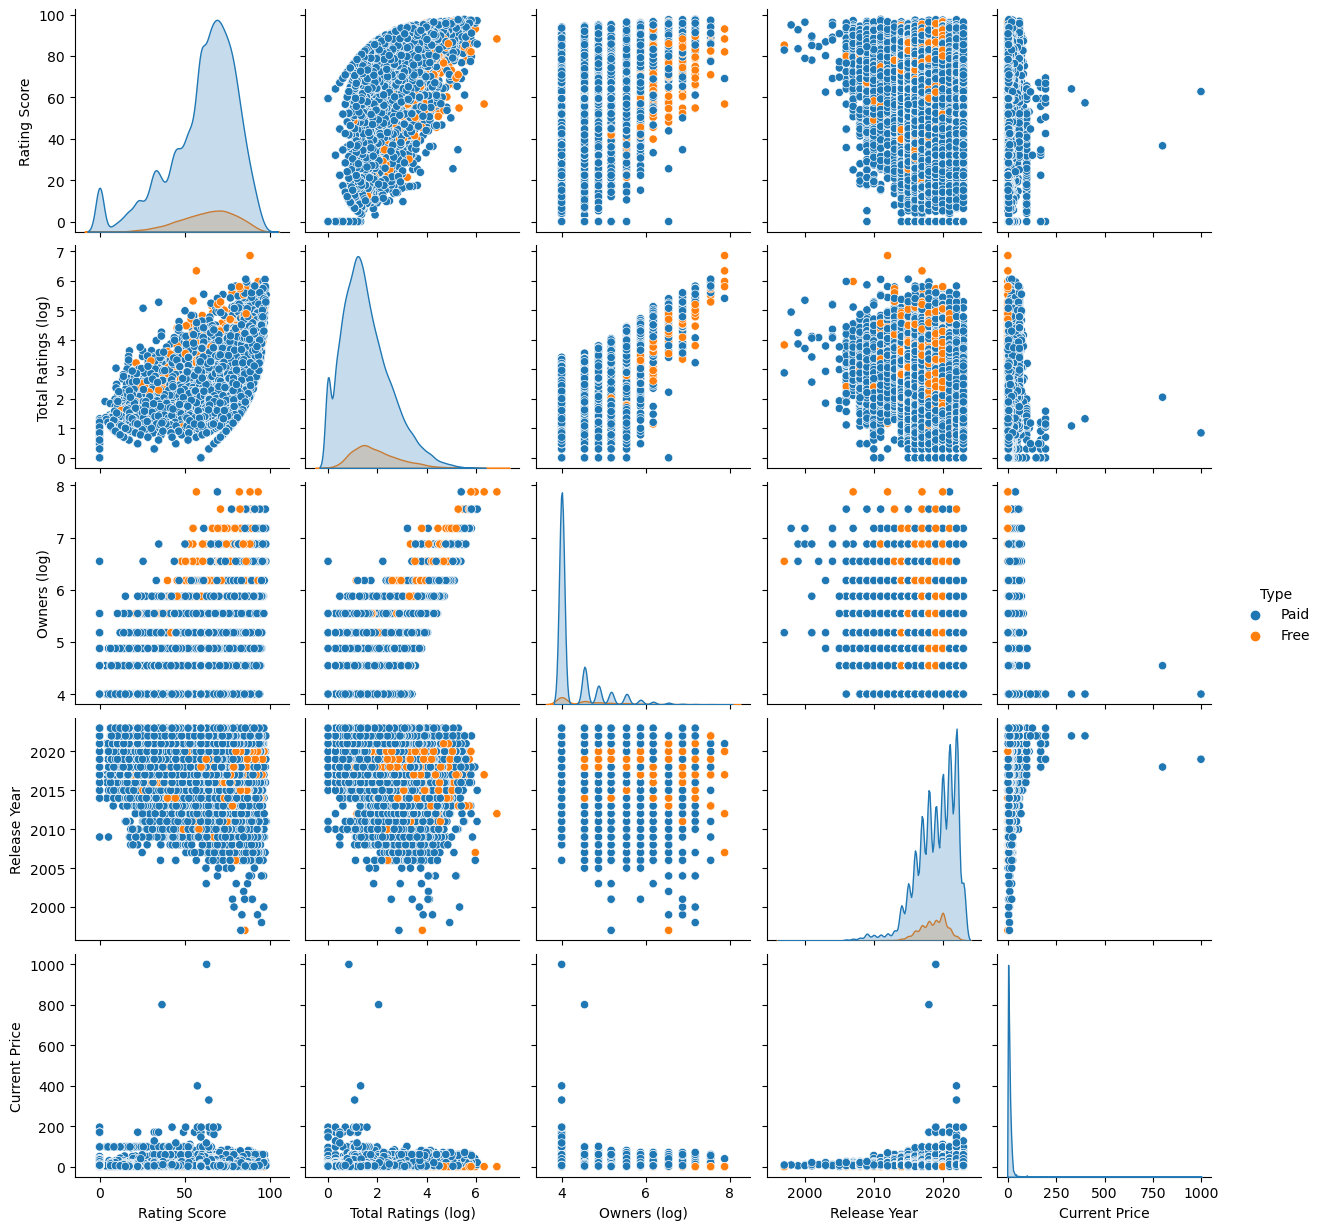

In [7]:
import warnings
warnings.filterwarnings('ignore')

# Create a column to split free vs paid games
data['type'] = 'Free'
data.loc[data['price'] > 0, 'type'] = 'Paid'

# ensure no 0s in columns we're applying log to
df = data[(data['median_owners'] > 0) & (data['total_ratings'] > 0)].copy()

eda_df = pd.DataFrame(zip(df['ratings'],
                          np.log10(df['total_ratings']),
                          np.log10(df['median_owners']),
                          df['release_year'],
                          df.price,
                          df['type']
                         ),
                      columns=['Rating Score', 'Total Ratings (log)', 'Owners (log)', 'Release Year', 'Current Price', 'Type'])

sns.pairplot(eda_df, hue='Type')
plt.show()

From this visualisation, we can make some initial observations:

- There are more paid games than free games
- Paid games have much higher ratings than free games
- Ratings for free games are more spread out
- More owners for paid games than free games
- The more owners of a game, the more ratings it has
- More paid games are released recently
- More recent games are more expensive

Based on the observations, we can make some initial conlusions:
- Ratings decreases overtime, suggesting that the newer the game is, the lower ratings it has.
- As price increases, ratings increase, suggesting that people are more likely to rate higher if they spend more money on that game.
- Higher ratings will be resulted from more owners, suggesting that games with more owners will gain higher ratings.

However, we cannot draw conclusions completely at this stage, we need further analysis on each factor including release year, generes, owners, pricing and delopers and publishers.

Now, let's do a simple heatmap to see the correlations between each columns


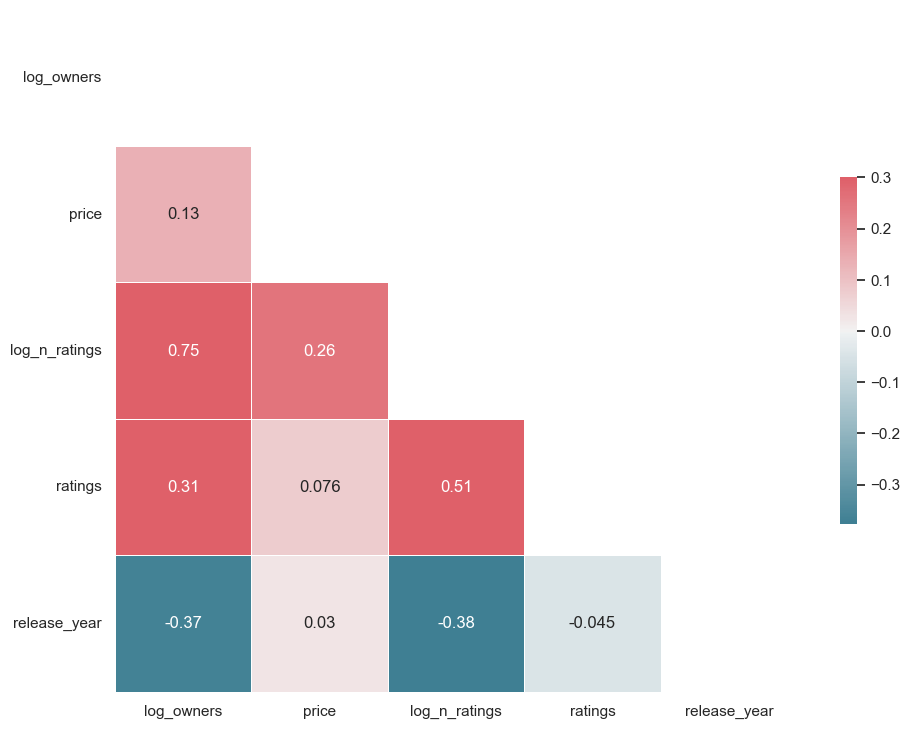

In [8]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style='white')
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    f, ax = plt.subplots(figsize=(11,9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    
    plt.yticks(rotation=0)
    plt.show()
    plt.rcdefaults()

corr_df = data.copy()
corr_df['log_owners'] = np.log10(corr_df['median_owners'])
corr_df['log_n_ratings'] = np.log10(corr_df['total_ratings'])

plot_correlation_heatmap(corr_df[['log_owners', 'price', 'log_n_ratings', 'ratings', 'release_year']])

Based on the initial correlations we found, let's do a closer check of each factor.

## Release Year

From the KDE we produced above, we can notice that rating scores seem to decrease overtime, but the number of releases has been increasing overtime. Now let's see this trend by using plots.



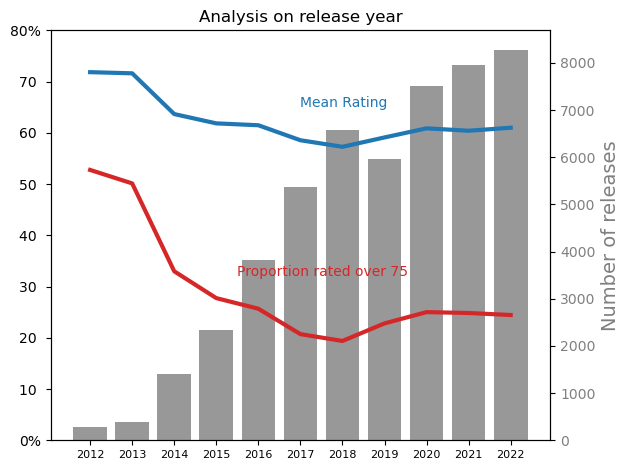

In [9]:
df = data.copy()

# we use 3/4 of total score (i.e 75) as an indicator of high ratings
rating_threshold = 75


# store useful values to each list
years = []
proportions = []
totals = []
avg_ratings = []
max_ratings = []


for year in sorted(df['release_year'].unique()):
    if year < 2012 or year > 2022:
        continue
    
    year_data = df[df['release_year'] == year]
    total = year_data.shape[0]
    high_rating = year_data[year_data['ratings'] >= rating_threshold].shape[0]
    avg_rating = year_data['ratings'].mean() / 100
    
    years.append(year)
    totals.append(total)
    proportions.append(high_rating/total)
    avg_ratings.append(avg_rating)
    

# plot_1: trendlines 
fig, plt1 = plt.subplots()
plt1.set_zorder(1)
plt1.patch.set_visible(False)

plt1.plot(avg_ratings, color='tab:blue', label='Average Rating', linewidth=3)
plt1.plot(proportions, color='tab:red', label=f'Proportion of games rated over {rating_threshold}', linewidth=3)

x_pos = np.arange(len(years))
plt1.set_xticks(x_pos)
plt1.set_xticklabels(years, fontsize=8)
plt1.set_yticks(np.arange(0, 0.9, 0.1))
plt1.set_yticklabels(['0%', '10 ', '20 ', '30 ', '40 ', '50 ', '60 ', '70 ', '80%'])

plt1.text(5, 0.65, 'Mean Rating', color='tab:blue')
plt1.text(3.5, 0.32, 'Proportion rated over 75', color='tab:red')

# plot_2: bar chart
plt2 = plt1.twinx()
color = 'tab:gray'
plt2.bar(x_pos, totals, color=color, alpha=.8)

plt2.set_ylabel('Number of releases', color=color, fontsize=14)
plt2.tick_params(axis='y', labelcolor=color)
plt2.set_title('Analysis on release year')

fig.tight_layout()
plt.show()

#### Conclusions:

1. Number of releases does increase overtime with a short drop between 2018 and 2019 which is not significant.

2. The mean rating dropped approximately by 10% in total, while there is a dramatic decrease between 2013 and 2014.

3. After 2013, under half of games are scored over 75, suggesting that high ratings are less likely to occur overtime.

## Categories, Genres and Steamspy_tags

Here, we want to draw a wordcloud to see which genres, categories or tags are more relevant. Also, we will focus on the tags for successful game. By defining successful games, we use "ratings >= 75" as an indicator.

In [10]:
data[data["ratings"] >= 75][["appid","name","categories","genres","steamspy_tags"]].head()

,appid,name,categories,genres,steamspy_tags
0,10,Counter-Strike,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer
1,20,Team Fortress Classic,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer
2,30,Day of Defeat,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer
3,40,Deathmatch Classic,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Classic
4,50,Half-Life: Opposing Force,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Classic


In [11]:
# first, define some functions for further use

def getTerm(data, variable):
    '''
    Get certain genre from the string
    '''
    terms = {}
    for line in data[variable].tolist():
        if ";" in line:
            line = line.split(";")
        else:
            line = [line]
        for x in line:
            if x not in terms:
                terms[x] = 1
            else:
                terms[x] += 1
    
    terms = {x:y for x, y in sorted(terms.items(), key = lambda x: x[1], reverse = True)}
    
    return terms


def splitTerm(data, variable, terms):
    '''
    Split each term in the string
    '''
    x_split = {key:[] for key in terms.keys()}
    for x in data[variable]:
        if ";" in x:
            x = x.split(";")
        else:
            x = [x]
        for key in x_split.keys():
            if key in x:
                x_split[key].append(1)
            else:
                x_split[key].append(0)
    
    x_data = pd.DataFrame(x_split)
    
    data_add = pd.merge(data, x_data , on = data.index)
    data_add.drop("key_0", axis = 1, inplace = True)
    
    return data_add

def drawWordCloud(freq_dict):
    '''
    Draw wordcloud for genres based on frequency
    '''
    wc = wordcloud.WordCloud(background_color="white", max_font_size=100, max_words=100, random_state=0).generate_from_frequencies(freq_dict)
    plt.figure(figsize=[8,6])
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off");

In [12]:
# define the terms we will use by using the functions above

cat_term = getTerm(data, "categories")
gen_term = getTerm(data, "genres")
tag_term = getTerm(data, "steamspy_tags")

data = splitTerm(data, "categories", cat_term)
data = splitTerm(data, "genres", gen_term)
data = splitTerm(data, "steamspy_tags", tag_term)

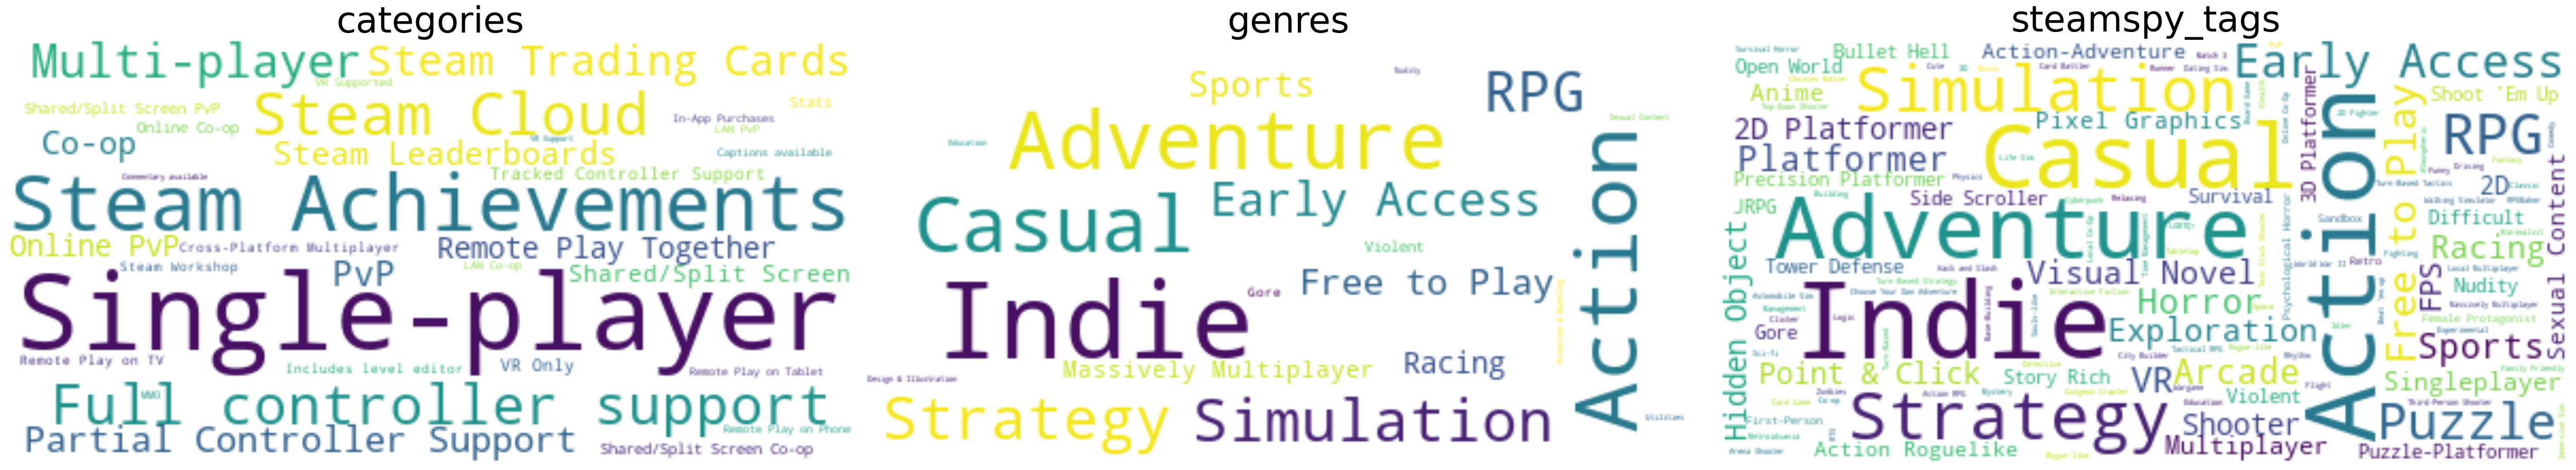

In [13]:
fig = plt.figure(figsize=[50,20])
list_term = [cat_term, gen_term, tag_term]
titles = ["categories", "genres", "steamspy_tags"]
for i in range(1,4):
    ax = fig.add_subplot(1,3,i)
    wc = wordcloud.WordCloud(background_color="white", max_font_size=50, random_state=0).generate_from_frequencies(list_term[i-1])
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off")
    ax.set_title(titles[i-1], size=50)
        
plt.tight_layout()
plt.show();

Now, we will focus on the 'popular' categories and genres as appeared on the wordcloud, and we will remove steamspy_tags as it overlaps with genres and categories.

In [14]:
def get_unique(series):
    """Get unique values from a Pandas series"""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

def process_cat_gen_tag(df):
    """Process categories, genres and steamspy_tags columns."""
    # get all unique category names
    cat_cols = get_unique(df['categories'])
    
    # only going to use main categories
    cat_cols = [
        # 'Local Multi-Player',
        # 'MMO',
        # 'Mods',
        'Multi-player',
        # 'Online Co-op',
        # 'Online Multi-Player',
        'Single-player'
    ]
    
    # create a new column for each category, with 1s indicating membership and 0s for non-members
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    # repeat for genre column names (get_unique used to find unique genre names, 
    # not necessary but useful if keeping all of them)
    gen_cols = get_unique(df['genres'])
    
    # only keeping 'main' genres appeared on the steam store website
    gen_cols = [
        # 'Accounting',
        'Action',
        'Adventure',
        # 'Animation & Modeling',
        # 'Audio Production',
        'Casual',
        # 'Design & Illustration',
        # 'Documentary',
        # 'Early Access',
        # 'Education',
        # 'Free to Play',
        # 'Game Development',
        # 'Gore',
        'Indie',
        'Massively Multiplayer',
        # 'Nudity',
        # 'Photo Editing',
        'RPG',
        'Racing',
        # 'Sexual Content',
        'Simulation',
        # 'Software Training',
        'Sports',
        'Strategy'
        # 'Tutorial',
        # 'Utilities',
        # 'Video Production',
        # 'Violent',
        # 'Web Publishing'
    ]
    
    gen_col_names = []
    
    # create new columns for each genre with 1s for games of that genre
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    # remove "non-games" based on genre
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()
    
    # remove redundant columns and return dataframe (keeping genres column for reference)
    df = df.drop(['categories', 'steamspy_tags'], axis=1)
    
    return df


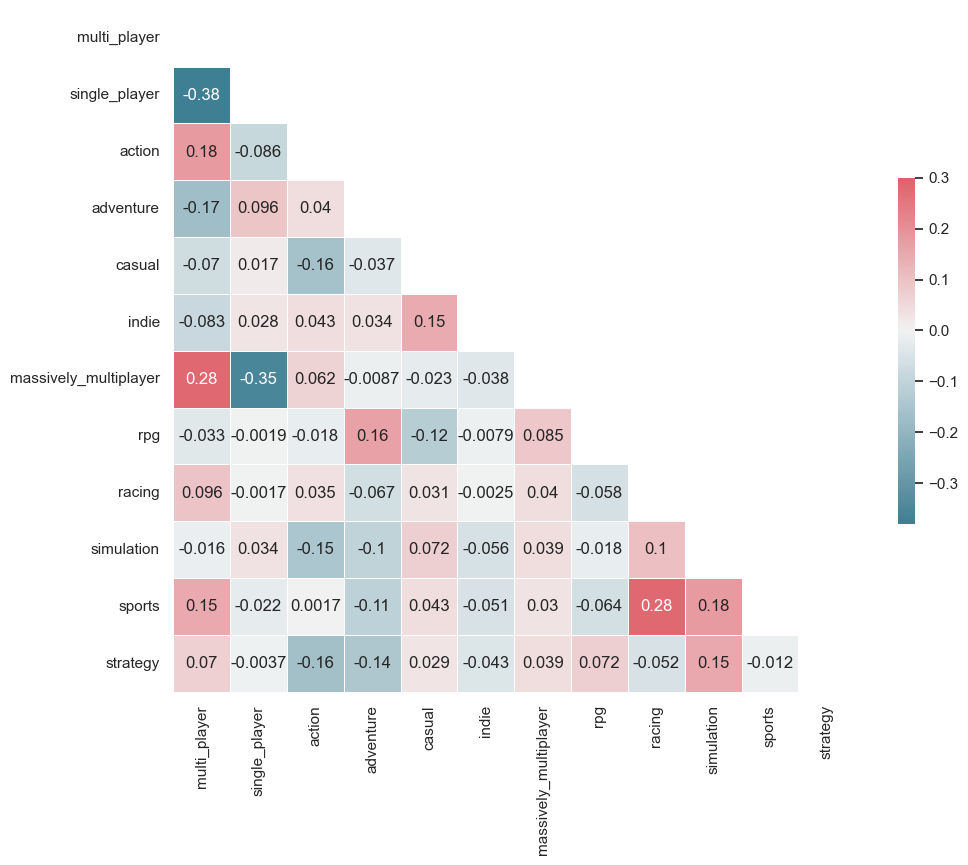

In [16]:
df = process_cat_gen_tag(data)

cat_gen_cols = df.columns[-12:]

plot_correlation_heatmap(df[cat_gen_cols])

We can see that there is correlation between different genres, which means one game can have several genres. It suggests that the high rating of a game may not depend on single genre or category, but here for simple analysis, we assume that the performance of each genres is independent.

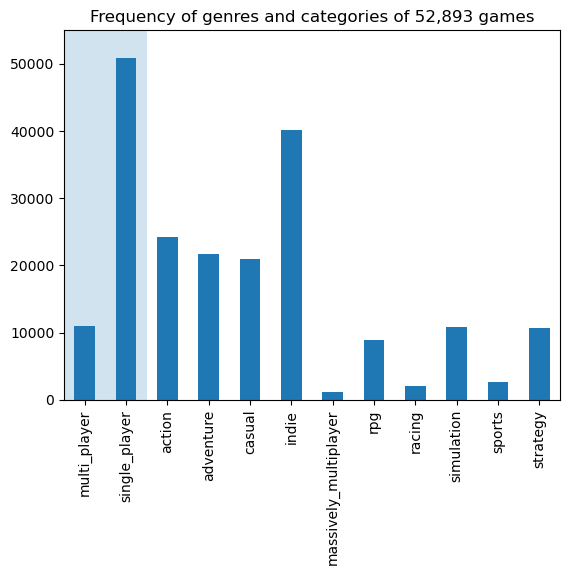

In [17]:
ax = df[cat_gen_cols].sum().plot.bar()

ax.fill_between([-.5, 1.5], 55000, alpha=.2)
ax.set_ylim([0, 55000])
ax.set_title(f'Frequency of genres and categories of {df.shape[0]:,} games')

plt.show()

Note that categorites are highlighted in blue. 

We can see that most games are categorised as 'single-player', and the genre of 'indie' takes the most percentage of all games. Also, 'massively_multiplayer', 'racing' and 'sports' games are the least.

Now, let's examine the performance of each genres based on the ratings by showing 'a rating distribution by genres'

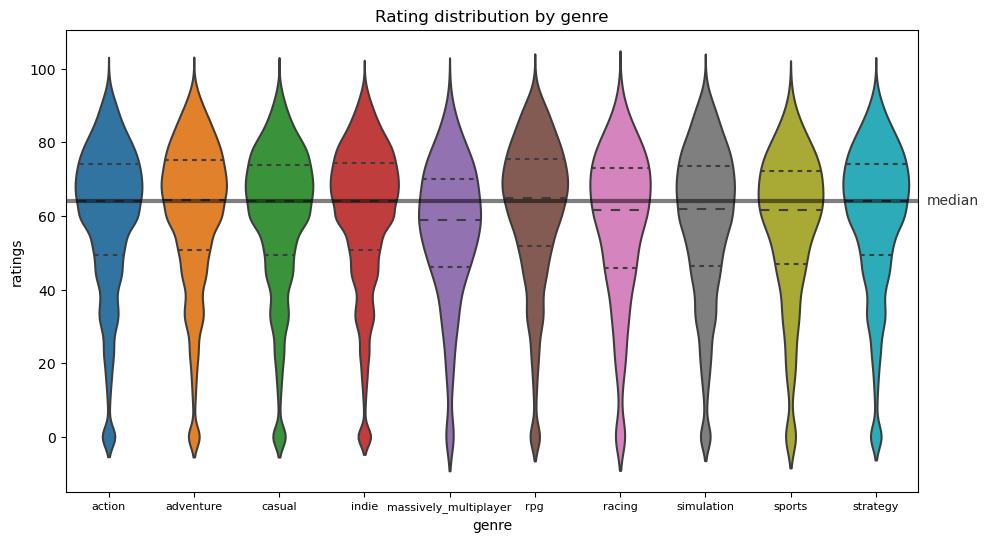

In [18]:
gen_cols = cat_gen_cols.drop(['multi_player', 'single_player'])

g_df = pd.DataFrame()

# create new dataframe with rating and genre, as games can belong to multiple genres
for col in gen_cols:
    rating = pd.DataFrame(df.loc[df[col] == 1, 'ratings'].values, columns=['ratings'])
    rating['genre'] = col
    g_df = pd.concat([g_df, rating], axis=0)

fig, ax = plt.subplots(figsize=(11,6))
sns.violinplot(x='genre', y='ratings', data=g_df, inner='quartile', ax=ax)
ax.axhline(g_df.ratings.median(), color='black', lw=3, alpha=.5)
ax.text(9.6, g_df.ratings.median()-1, 'median', color='black', alpha=.8)

ax.tick_params(axis='x', labelsize=8)
ax.set_title("Rating distribution by genre");
plt.show()

we can see that Massively Multiplayer games tend to have much lower ratings than any other genre and RPG games have slightly better ratings than most.

#### Conclusions:

1. More games are categorised as single-player, but its correlation with rating is not examined here.

2. High frequency does not mean higher ratings. Indie genre take the highest frequency, but it doesn't seem to contribute to a higher rating.

3. Massively Multiplayer games take the least proportion, and it contributes to lower ratings as well.

4. But lower frequency does not mean lower ratings. Although RPG games only take a small proportion of all games, it has a slightly higher rating than others.


## Developers and Publishers

Despite the genres and categories, we also want to see the performance of developers and publishers in correlation with ratings.

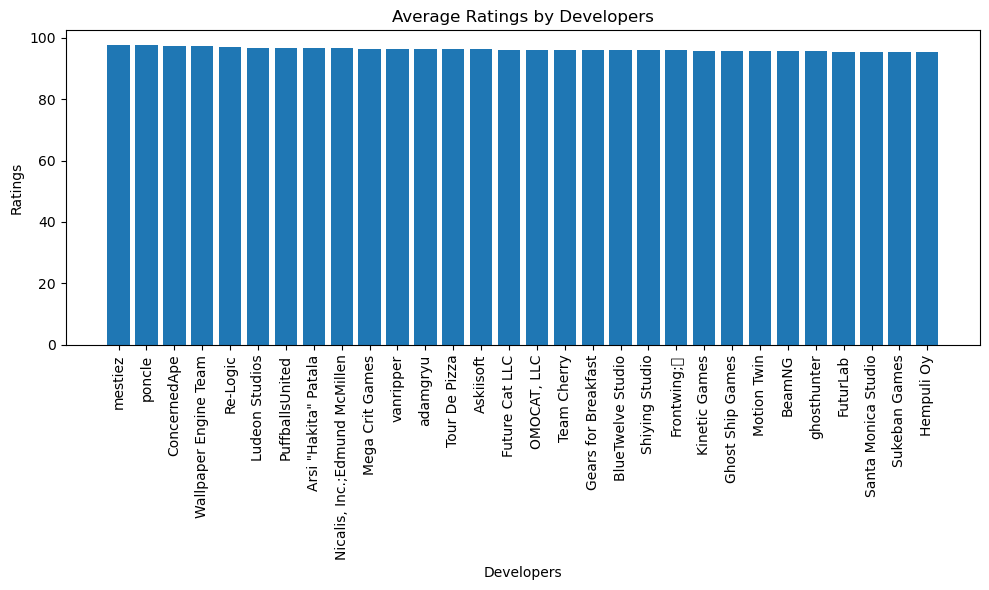

In [19]:
pv = df.pivot_table(index='developer', 
               values=['appid', 'ratings'], 
               aggfunc={'appid':'count', 'ratings':np.mean})

pv = pv.rename({'appid':'num_releases'}, axis=1).sort_values(by='ratings', ascending=False)

pv = pv.head(30)


ratings = pv['ratings']
developers = pv.index

plt.figure(figsize=(10, 6))
plt.bar(developers, ratings)
plt.xlabel('Developers')
plt.ylabel('Ratings')
plt.title('Average Ratings by Developers')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

As we can see that there is nearly no correlations between developer and ratings. It can be explained as one developer tends to develop many different genres of games, where genres seem to have greater influence on ratings.